In [5]:
import numpy as np
import pandas as pd
import os,re,sys,random
from random import randint
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import confusion_matrix
from sklearn.metrics import  precision_recall_fscore_support
from scipy import interp
from sklearn.utils import resample, shuffle
from matplotlib import pyplot as plt
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [7]:
random_state=np.random.RandomState(seed=527)
best_params_ = {'subsample': 0.7526315789473684, 'n_estimators': 380, 'min_child_weight': 3, 'max_depth': 40, 'learning_rate': 0.01, 'gamma': 0.1, 'colsample_bytree': 0.6599999999999999}

In [11]:
def draw_cv_roc_and_pr_curve_xgboost(X,y,clf,random_state):
    
    # Run classifier with cross-validation and plot ROC curves
    fig, ax = plt.subplots(figsize=(5,5))
    classifier = clf
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    
    cv = StratifiedKFold(n_splits=5,random_state=random_state,shuffle=True)
    
    i = 0
    for train, test in cv.split(X, y):
        clf= classifier.fit(X[train], y[train])
        probas_ = clf.predict_proba(X[test])
        fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=1.5, alpha=0.5,  label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
        
        i = i + 1
        
    ax.plot([0, 1], [0, 1], linestyle='--', lw=3.5, color='r',
             label='Luck', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=3.5, alpha=.8)
    
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')

    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel('False Positive Rate (FPR)',fontsize=12)
    ax.set_ylabel('True Positive Rate (TPR)',fontsize=12)
    plt.legend(loc="lower right",fontsize=10)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.show()

In [12]:
feature_name =["ASA_SCORE","DSS_SCORE","FCONS_SCORE","COIL","ANCHOR_SCORE","nflanking_ptms","nflanking_ub_lysines","HELIX","RIG_SCORE","Domain_pfam"]
lable_identifier = "IS_DEGRON"

path_base ="/public/home/hxu6/projects/degron/DegronsDB/data_patterns" 

path_features = os.path.join(path_base,"annotated_degrons_properties.tsv")
annotated_degron = pd.read_csv(path_features,sep="\t")
positives = annotated_degron[feature_name]                    
positives[lable_identifier] = 1.0

path_negative_pep = os.path.join(path_base,"simulated_degrons.tsv.gz") 
negative_pep = pd.read_csv(path_negative_pep,sep="\t",compression="gzip")
negative_pep = negative_pep[negative_pep["CONS_SCORE"]>0]
negative_pep=negative_pep.dropna(axis=0)
N = positives.shape[0]

negatives_random = negative_pep.sample(n=5*len(positives), replace=True, random_state=2024509)

negatives = negatives_random[feature_name]                    
negatives[lable_identifier] = 0.0
training_data = pd.concat([positives,negatives])
training_data.dropna(how="any",axis=0,inplace=True)
X = training_data[feature_name].values
y = training_data[lable_identifier].values
X_train, y_train = shuffle(X, y, random_state=42)

/public/home/hxu6/anaconda3/envs/tens37/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/public/home/hxu6/anaconda3/envs/tens37/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


/public/home/hxu6/anaconda3/envs/tens37/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/public/home/hxu6/anaconda3/envs/tens37/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/public/home/hxu6/anaconda3/envs/tens37/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/public/home/hxu6/anaconda3/envs/tens37/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/public/home/hxu6/anaconda3/envs/tens37/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.inter

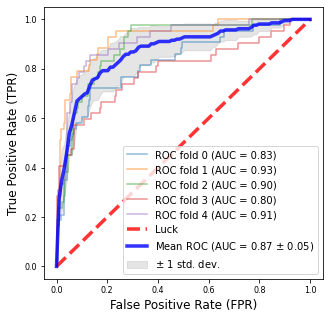

In [13]:
clf_random = xgb.XGBClassifier(**best_params_)
draw_cv_roc_and_pr_curve_xgboost(X_train,y_train,clf_random,random_state)